# Detailed Analysis of Student Data Processing

I will analyze each step of the code, providing explanations and improvement recommendations, along with suggestions for developing an application based on this data.

In [17]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import warnings
from sklearn.utils import resample
warnings.filterwarnings('ignore')

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Create necessary directories if they don't exist
os.makedirs('../data/processed', exist_ok=True)

## STEP 1: Analysis and exploration of dataset structure
### Explanation:
- The code loads a CSV file ("dataset_original.csv") with university student data
- Shows the first 5 rows of the dataset
- Presents information about data types and basic statistics
- Reviews the distribution of the target variable (target)

In [18]:
print("🔍 STEP 1: Analyzing and exploring dataset structure...")

df = pd.read_csv("../data/raw/dataset.csv")  
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

# Display basic information about the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

print("\nUnique values in target variable:")
print(df['target'].value_counts())


🔍 STEP 1: Analyzing and exploring dataset structure...
Dataset loaded with 4424 rows and 35 columns.

First 5 rows of the dataset:
   Marital status  Application mode  Application order  Course  Daytime/evening attendance  Previous qualification  Nacionality  Mother's qualification  Father's qualification  Mother's occupation  \
0               1                 8                  5       2                           1                       1            1                      13                      10                    6   
1               1                 6                  1      11                           1                       1            1                       1                       3                    4   
2               1                 1                  5       5                           1                       1            1                      22                      27                   10   
3               1                 8                  2      15       

## STEP 2: Identification of data quality issues
### Explanation:
- Looks for missing values in all columns
- Detects duplicate rows
- Identifies possible zero values in grade columns that could represent missing data
- Examines inconsistencies in categorical columns
- Detects outliers in numerical columns

In [19]:
print("\n🔎 STEP 2: Identifying and reporting data quality issues...")

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0] if missing_values.any() > 0 else "No missing values found")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Check for zeros in grade columns that might represent missing data
grade_cols = [col for col in df.columns if 'grade' in col.lower()]
for col in grade_cols:
    zero_count = (df[col] == 0.0).sum()
    if zero_count > 0:
        print(f"Column '{col}' has {zero_count} zero values that might represent missing data")

# Check for inconsistencies in categorical columns
categorical_cols = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
                   'Previous qualification', 'Nacionality', 'Gender', 'Displaced', 
                   'Educational special needs', 'Debtor', 'Tuition fees up to date',
                   'Scholarship holder', 'International', 'target']

for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())

# Check for outliers in numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
print("\nChecking for outliers in numerical columns...")
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"Column '{col}' has {outliers} potential outliers")


🔎 STEP 2: Identifying and reporting data quality issues...

Missing values per column:
No missing values found

Number of duplicate rows: 0
Column 'Curricular units 1st sem (grade)' has 718 zero values that might represent missing data
Column 'Curricular units 2nd sem (grade)' has 870 zero values that might represent missing data

Unique values in 'Marital status':
Marital status
1    3919
2     379
4      91
5      25
6       6
3       4
Name: count, dtype: int64

Unique values in 'Application mode':
Application mode
1     1708
8      872
12     785
14     312
15     213
4      139
9      124
13      77
16      59
7       38
17      35
6       30
3       16
5       10
2        3
18       1
10       1
11       1
Name: count, dtype: int64

Unique values in 'Course':
Course
12    766
9     380
10    355
6     337
15    331
14    268
17    268
11    252
5     226
2     215
3     215
4     210
16    192
7     170
8     141
13     86
1      12
Name: count, dtype: int64

Unique values in 'D

## STEP 3: Mapping and cleaning of categorical and numerical values
### Explanation:
- Defines detailed dictionaries to convert numeric codes into descriptive categories
- Applies these mappings to categorical columns (marital status, application mode, course, etc.)
- Transforms binary variables (0/1) to "No"/"Yes" values
- Saves an intermediate dataset after mapping

In [20]:
print("\n🔄 STEP 3: Mapping and cleaning categorical and numeric values...")

# Define mapping dictionaries based on provided information
marital_status_map = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Common-law marriage',
    6: 'Legally separated'
}

application_mode_map = {
    1: '1st phase—general contingent',
    2: 'Ordinance No. 612/93',
    3: '1st phase—special contingent (Azores)',
    4: 'Holders of other higher courses',
    5: 'Ordinance No. 854-B/99',
    6: 'International student (bachelor)',
    7: '1st phase—special contingent (Madeira)',
    8: '2nd phase—general contingent',
    9: '3rd phase—general contingent',
    10: 'Ordinance No. 533-A/99 (Different Plan)',
    11: 'Ordinance No. 533-A/99 (Other Institution)',
    12: 'Over 23 years old',
    13: 'Transfer',
    14: 'Change in course',
    15: 'Technological specialization diploma',
    16: 'Change in institution/course',
    17: 'Short cycle diploma holders',
    18: 'Change in institution/course (International)'
}

course_map = {
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equiniculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening)'
}

previous_qualification_map = {
    1: 'Secondary education',
    2: 'Higher education—bachelor',
    3: 'Higher education—degree',
    4: 'Higher education—master',
    5: 'Higher education—doctorate',
    6: 'Frequency of higher education',
    7: '12th year—not completed',
    8: '11th year—not completed',
    9: 'Other—11th year',
    10: '10th year',
    11: '10th year—not completed',
    12: 'Basic education 3rd cycle',
    13: 'Basic education 2nd cycle',
    14: 'Technological specialization course',
    15: 'Higher education—degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education—master (2nd cycle)'
}

# Simplified qualification map for parents (combining similar categories)
parent_qualification_map = {
    1: 'Secondary Education',
    2: 'Higher Education—bachelor',
    3: 'Higher Education—degree',
    4: 'Higher Education—master',
    5: 'Higher Education—doctorate',
    6: 'Some Higher Education',
    7: '12th Year—not completed',
    8: '11th Year—not completed',
    9: '7th Year (Old)',
    10: 'Other—11th Year',
    11: '2nd year complementary',
    12: '10th Year',
    13: 'General commerce course',
    14: 'Basic Education 3rd Cycle',
    15: 'Complementary High School',
    16: 'Technical-professional course',
    17: 'Complementary High School—not concluded',
    18: '7th year',
    19: '2nd cycle general high school',
    20: '9th Year—not completed',
    21: '8th year',
    22: 'General Administration and Commerce',
    23: 'Supplementary Accounting and Administration',
    24: 'Unknown',
    25: 'Cannot read or write',
    26: 'Can read without 4th year',
    27: 'Basic education 1st cycle',
    28: 'Basic Education 2nd Cycle',
    29: 'Technological specialization course',
    30: 'Higher education—degree (1st cycle)',
    31: 'Specialized higher studies',
    32: 'Professional higher technical',
    33: 'Higher Education—master (2nd cycle)',
    34: 'Higher Education—doctorate (3rd cycle)'
}

# Simplified occupation map (grouping into broader categories)
occupation_map = {
    1: 'Student',
    2: 'Executive/Director',
    3: 'Intellectual/Scientific Specialist',
    4: 'Technician',
    5: 'Administrative Staff',
    6: 'Service/Sales Worker',
    7: 'Agricultural Worker',
    8: 'Industry/Construction Worker',
    9: 'Machine Operator',
    10: 'Unskilled Worker',
    11: 'Armed Forces',
    12: 'Other',
    13: 'Armed Forces Officer',
    14: 'Armed Forces Sergeant',
    15: 'Other Armed Forces',
    16: 'Administrative Director',
    17: 'Service Director',
    18: 'Science/Engineering Specialist',
    19: 'Health Professional',
    20: 'Teacher',
    21: 'Finance/Accounting Specialist',
    22: 'Science/Engineering Technician',
    23: 'Health Technician',
    24: 'Legal/Social Technician',
    25: 'IT Technician',
    26: 'Office Worker',
    27: 'Data Operator',
    28: 'Administrative Support',
    29: 'Personal Service Worker',
    30: 'Seller',
    31: 'Care Worker',
    32: 'Security Personnel',
    33: 'Agricultural Worker',
    34: 'Subsistence Worker',
    35: 'Construction Worker',
    36: 'Metalworker',
    37: 'Electrical Worker',
    38: 'Food/Wood/Clothing Worker',
    39: 'Plant Operator',
    40: 'Assembly Worker',
    41: 'Vehicle Driver',
    42: 'Agricultural Laborer',
    43: 'Industry Laborer',
    44: 'Meal Preparation Assistant',
    45: 'Street Vendor'
}

nationality_map = {
    1: 'Portuguese',
    2: 'German',
    3: 'Spanish',
    4: 'Italian',
    5: 'Dutch',
    6: 'English',
    7: 'Lithuanian',
    8: 'Angolan',
    9: 'Cape Verdean',
    10: 'Guinean',
    11: 'Mozambican',
    12: 'Santomean',
    13: 'Turkish',
    14: 'Brazilian',
    15: 'Romanian',
    16: 'Moldovan',
    17: 'Mexican',
    18: 'Ukrainian',
    19: 'Russian',
    20: 'Cuban',
    21: 'Colombian'
}

# Binary mappings
binary_mapping = {
    'Displaced': {0: 'No', 1: 'Yes'},
    'Educational special needs': {0: 'No', 1: 'Yes'},
    'Debtor': {0: 'No', 1: 'Yes'},
    'Tuition fees up to date': {0: 'No', 1: 'Yes'},
    'Gender': {0: 'Female', 1: 'Male'},
    'Scholarship holder': {0: 'No', 1: 'Yes'},
    'International': {0: 'No', 1: 'Yes'},
    'Daytime/evening attendance': {0: 'Evening', 1: 'Daytime'}
}

# Apply mappings to the dataset
df['Marital status'] = df['Marital status'].map(marital_status_map)
df['Application mode'] = df['Application mode'].map(application_mode_map)
df['Course'] = df['Course'].map(course_map)
df['Previous qualification'] = df['Previous qualification'].map(previous_qualification_map)
df["Mother's qualification"] = df["Mother's qualification"].map(parent_qualification_map)
df["Father's qualification"] = df["Father's qualification"].map(parent_qualification_map)
df["Mother's occupation"] = df["Mother's occupation"].map(occupation_map)
df["Father's occupation"] = df["Father's occupation"].map(occupation_map)
df['Nacionality'] = df['Nacionality'].map(nationality_map)

# Apply binary mappings
for col, mapping in binary_mapping.items():
    df[col] = df[col].map(mapping)
    print(f"Column '{col}' converted to categories: {mapping}")



🔄 STEP 3: Mapping and cleaning categorical and numeric values...
Column 'Displaced' converted to categories: {0: 'No', 1: 'Yes'}
Column 'Educational special needs' converted to categories: {0: 'No', 1: 'Yes'}
Column 'Debtor' converted to categories: {0: 'No', 1: 'Yes'}
Column 'Tuition fees up to date' converted to categories: {0: 'No', 1: 'Yes'}
Column 'Gender' converted to categories: {0: 'Female', 1: 'Male'}
Column 'Scholarship holder' converted to categories: {0: 'No', 1: 'Yes'}
Column 'International' converted to categories: {0: 'No', 1: 'Yes'}
Column 'Daytime/evening attendance' converted to categories: {0: 'Evening', 1: 'Daytime'}


## STEP 4: Translation and standardization of columns to English
### Explanation:
- Converts column names to snake_case format
- Standardizes names by removing spaces, parentheses and other special characters
- Corrects specific terms like "nacionality" to "nationality"
- Saves an intermediate dataset with standardized columns

In [21]:
print("\n🧹 STEP 4: Translating and standardizing column names...")
# Convert to snake_case and standardize names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/', '_').str.replace("'", '').str.replace(',', '')

# Correct specific column names (like nationality)
column_name_corrections = {
    'nacionality': 'nationality',
    'mothers_qualification': 'mother_qualification',
    'fathers_qualification': 'father_qualification',
    'mothers_occupation': 'mother_occupation',
    'fathers_occupation': 'father_occupation'
}

df = df.rename(columns=column_name_corrections)
print("New column names:")
print(df.columns.tolist())



🧹 STEP 4: Translating and standardizing column names...
New column names:
['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'nationality', 'mother_qualification', 'father_qualification', 'mother_occupation', 'father_occupation', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'international', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations', 'unemployment_rate', 'inflation_rate', 'gdp', 'target']


## STEP 5: Creation and imputation of derived features
### Explanation:
- Creates age groups based on ranges
- Calculates approval rates for first and second semesters
- Generates grade improvement indicator between semesters
- Creates academic load and performance indicators
- Categorizes economic context based on unemployment rate
- Normalizes the target variable

In [22]:
print("\n⚙️ STEP 5: Creating and imputing derived features...")

# Categorize age
df['age_group'] = pd.cut(
    df['age_at_enrollment'], 
    bins=[17, 22, 30, 40, 100],
    labels=['18-22', '23-30', '31-40', '40+']
)
print("Variable 'age_group' created to categorize ages")

# Calculate approval rates
# First semester
df['first_sem_approval_rate'] = df['curricular_units_1st_sem_approved'] / df['curricular_units_1st_sem_enrolled']
# Second semester
df['second_sem_approval_rate'] = df['curricular_units_2nd_sem_approved'] / df['curricular_units_2nd_sem_enrolled']
print("Approval rate variables created for both semesters")

# Calculate performance difference between semesters
df['grade_improvement'] = df['curricular_units_2nd_sem_grade'] - df['curricular_units_1st_sem_grade']
print("Variable 'grade_improvement' created to measure improvement between semesters")

# Create academic dedication indicator
df['academic_load'] = pd.cut(
    df['curricular_units_1st_sem_enrolled'] + df['curricular_units_2nd_sem_enrolled'],
    bins=[0, 8, 16, 30, 100],
    labels=['Low', 'Medium', 'High', 'Very High']
)
print("Variable 'academic_load' created to indicate academic workload")

# Create general academic performance indicator
df['academic_performance'] = (
    (df['curricular_units_1st_sem_approved'] / df['curricular_units_1st_sem_enrolled']).fillna(0) + 
    (df['curricular_units_2nd_sem_approved'] / df['curricular_units_2nd_sem_enrolled']).fillna(0)
) / 2

df['academic_performance_category'] = pd.cut(
    df['academic_performance'],
    bins=[-0.001, 0.3, 0.7, 1.001],
    labels=['Low', 'Medium', 'High']
)
print("Academic performance variables created")

# Create economic context variable
df['economic_context'] = pd.cut(
    df['unemployment_rate'],
    bins=[0, 10, 13, 16, 20],
    labels=['Low Unemployment', 'Moderate Unemployment', 'High Unemployment', 'Very High Unemployment']
)
print("Economic context variable created based on unemployment rate")

# Normalize the target variable for clarity
target_mapping = {
    'Dropout': 'Dropout',
    'Graduate': 'Graduate',
    'Enrolled': 'Enrolled'
}
df['target'] = df['target'].map(target_mapping)
print(f"Variable 'target' normalized: {df['target'].unique().tolist()}")



⚙️ STEP 5: Creating and imputing derived features...
Variable 'age_group' created to categorize ages
Approval rate variables created for both semesters
Variable 'grade_improvement' created to measure improvement between semesters
Variable 'academic_load' created to indicate academic workload
Academic performance variables created
Economic context variable created based on unemployment rate
Variable 'target' normalized: ['Dropout', 'Graduate', 'Enrolled']


## STEP 6: Handling missing values and duplicates
### Explanation:
- Replaces zero values in grade columns with NaN when representing missing evaluations
- Imputes missing values in approval rates with zeros
- Imputes missing values in grade improvements with zeros
- Removes duplicate rows
- Verifies remaining missing values

In [23]:
print("\n❓ STEP 6: Handling missing values and duplicates...")

# Handle zeros in grade columns that represent missing data
grade_cols = [col for col in df.columns if 'grade' in col]
for col in grade_cols:
    # Check if there are rows with 0 in grades
    zero_mask = (df[col] == 0.0)
    if zero_mask.any():
        print(f"Column '{col}' has {zero_mask.sum()} values with 0.0 that might be NaN")
        # Replace 0 with NaN when it represents absence of evaluation
        df.loc[zero_mask, col] = np.nan

# Replace NaN in approval rates when there are no enrolled units
df['first_sem_approval_rate'] = df['first_sem_approval_rate'].fillna(0)
df['second_sem_approval_rate'] = df['second_sem_approval_rate'].fillna(0)
print("Null values in approval rates replaced with 0")

# Replace NaN in grade improvement when data is missing
df['grade_improvement'] = df['grade_improvement'].fillna(0)
print("Null values in grade improvement replaced with 0")

# Check for and remove duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")
else:
    print("No duplicate rows found")

# Check remaining missing values
missing_values = df.isnull().sum()
print("\nRemaining missing values per column:")
print(missing_values[missing_values > 0] if missing_values.any() > 0 else "No missing values remaining")



❓ STEP 6: Handling missing values and duplicates...
Column 'curricular_units_1st_sem_grade' has 718 values with 0.0 that might be NaN
Column 'curricular_units_2nd_sem_grade' has 870 values with 0.0 that might be NaN
Column 'grade_improvement' has 1149 values with 0.0 that might be NaN
Null values in approval rates replaced with 0
Null values in grade improvement replaced with 0
No duplicate rows found

Remaining missing values per column:
father_occupation                   1
curricular_units_1st_sem_grade    718
curricular_units_2nd_sem_grade    870
age_group                           5
academic_load                     180
dtype: int64


## STEP 7: Export of clean dataset to CSV and PKL
### Explanation:
- Saves clean dataset in CSV format
- Saves dataset in pickle format for Python use
- Creates a data dictionary with column descriptions
- Documents performed transformations

In [24]:
print("\n✅ STEP 7: Exporting clean dataset to CSV and PKL...")

# Save the clean dataset to CSV
df.to_csv("../data/processed/clean_student_data.csv", index=False)
print("Clean dataset saved as 'data/processed/clean_student_data.csv'")

# Save the clean dataset to PKL
with open('../data/processed/clean_student_data.pkl', 'wb') as f:
    pickle.dump(df, f)
print("Clean dataset saved as 'data/processed/clean_student_data.pkl'")

# Create a data dictionary
data_dict = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Description': [
        'Marital status of student',
        'Application mode to the course',
        'Order of application preference',
        'Course enrolled',
        'Daytime or evening attendance',
        'Previous qualification before enrollment',
        'Nationality of student',
        'Mother\'s qualification',
        'Father\'s qualification',
        'Mother\'s occupation',
        'Father\'s occupation',
        'Whether student is displaced from home',
        'Whether student has special educational needs',
        'Whether student is a debtor',
        'Whether tuition fees are up to date',
        'Gender of student',
        'Whether student holds a scholarship',
        'Age at enrollment',
        'Whether student is international',
        'Curricular units credited in 1st semester',
        'Curricular units enrolled in 1st semester',
        'Curricular units evaluated in 1st semester',
        'Curricular units approved in 1st semester',
        'Grade average in 1st semester',
        'Curricular units without evaluations in 1st semester',
        'Curricular units credited in 2nd semester',
        'Curricular units enrolled in 2nd semester',
        'Curricular units evaluated in 2nd semester',
        'Curricular units approved in 2nd semester',
        'Grade average in 2nd semester',
        'Curricular units without evaluations in 2nd semester',
        'Unemployment rate',
        'Inflation rate',
        'GDP',
        'target outcome (Dropout, Graduate, or Enrolled)',
        'Age group category',
        'Approval rate in 1st semester',
        'Approval rate in 2nd semester',
        'Grade improvement between semesters',
        'Academic workload category',
        'Overall academic performance',
        'Academic performance category',
        'Economic context based on unemployment rate'
    ]
})

# Save data dictionary
data_dict.to_csv("../data/processed/data_dictionary.csv", index=False)
print("Data dictionary saved as '../data/processed/data_dictionary.csv'")


✅ STEP 7: Exporting clean dataset to CSV and PKL...
Clean dataset saved as 'data/processed/clean_student_data.csv'
Clean dataset saved as 'data/processed/clean_student_data.pkl'
Data dictionary saved as '../data/processed/data_dictionary.csv'


## STEP 8: Generation of synthetic training data
### Explanation:
- Defines detailed function to generate synthetic students
- Creates 200 artificial records following original dataset distribution (si agrego 2000 el overfiting baja a 13 aprox.)
- Adjusts performance features according to target variable for greater realism
- Saves synthetic data and combines with original

In [31]:
print("\n🔄 STEP 8: Generating synthetic data for training...")

# Function to generate synthetic student data
def generate_synthetic_students(n_samples=100, original_df=None):
    synthetic_data = []
    
    # Get unique values from original dataframe for more realistic synthetic data
    marital_statuses = original_df['marital_status'].unique()
    application_modes = original_df['application_mode'].unique()
    courses = original_df['course'].unique()
    attendance_types = original_df['daytime_evening_attendance'].unique()
    qualifications = original_df['previous_qualification'].unique()
    nationalities = original_df['nationality'].unique()
    mother_quals = original_df['mother_qualification'].unique()
    father_quals = original_df['father_qualification'].unique()
    mother_occs = original_df['mother_occupation'].unique()
    father_occs = original_df['father_occupation'].unique()
    binary_yes_no = ['Yes', 'No']
    gender_values = ['Male', 'Female']
    age_groups = original_df['age_group'].unique()
    academic_loads = original_df['academic_load'].unique()
    performance_categories = original_df['academic_performance_category'].unique()
    targets = ['Dropout', 'Graduate', 'Enrolled']
    economic_contexts = original_df['economic_context'].unique()
    
    # Generate synthetic students
    for _ in range(n_samples):
        # Basic demographic data
        age = np.random.randint(18, 60)
        if age <= 22:
            age_group = '18-22'
        elif age <= 30:
            age_group = '23-30'
        elif age <= 40:
            age_group = '31-40'
        else:
            age_group = '40+'
            
        gender = np.random.choice(gender_values)
        marital = np.random.choice(marital_statuses)
        nationality = np.random.choice(nationalities)
        international = np.random.choice(binary_yes_no, p=[0.05, 0.95])  # 5% international
        
        # Academic background
        prev_qualification = np.random.choice(qualifications)
        mother_qual = np.random.choice(mother_quals)
        father_qual = np.random.choice(father_quals)
        mother_occ = np.random.choice(mother_occs)
        father_occ = np.random.choice(father_occs)
        
        # Application details
        app_mode = np.random.choice(application_modes)
        app_order = np.random.randint(1, 7)
        course = np.random.choice(courses)
        day_evening = np.random.choice(attendance_types)
        
        # Financial and special conditions
        displaced = np.random.choice(binary_yes_no, p=[0.65, 0.35])
        special_needs = np.random.choice(binary_yes_no, p=[0.99, 0.01])
        debtor = np.random.choice(binary_yes_no, p=[0.85, 0.15])
        fees_up_to_date = np.random.choice(binary_yes_no, p=[0.9, 0.1])
        scholarship = np.random.choice(binary_yes_no, p=[0.8, 0.2])
        
        # First semester performance
        units_1st_credited = np.random.randint(0, 8)
        units_1st_enrolled = np.random.randint(5, 9)
        units_1st_evaluations = np.random.randint(0, units_1st_enrolled * 2)
        units_1st_approved = np.random.randint(0, units_1st_enrolled + 1)
        units_1st_grade = np.random.uniform(0, 15) if units_1st_approved > 0 else 0
        units_1st_without_eval = np.random.randint(0, 3)
        
        # Second semester performance
        units_2nd_credited = np.random.randint(0, 8)
        units_2nd_enrolled = np.random.randint(5, 9)
        units_2nd_evaluations = np.random.randint(0, units_2nd_enrolled * 2)
        units_2nd_approved = np.random.randint(0, units_2nd_enrolled + 1)
        units_2nd_grade = np.random.uniform(0, 15) if units_2nd_approved > 0 else 0
        units_2nd_without_eval = np.random.randint(0, 3)
        
        # Economic indicators
        economic_context = np.random.choice(economic_contexts)
        unemployment = np.random.uniform(7.5, 16.5)
        inflation = np.random.uniform(-1.0, 4.0)
        gdp = np.random.uniform(-4.5, 4.0)
        
        # Derived variables
        first_sem_rate = units_1st_approved / units_1st_enrolled if units_1st_enrolled > 0 else 0
        second_sem_rate = units_2nd_approved / units_2nd_enrolled if units_2nd_enrolled > 0 else 0
        grade_improvement = units_2nd_grade - units_1st_grade
        
        academic_load = 'Low'
        total_load = units_1st_enrolled + units_2nd_enrolled
        if total_load <= 8:
            academic_load = 'Low'
        elif total_load <= 16:
            academic_load = 'Medium'
        elif total_load <= 30:
            academic_load = 'High'
        else:
            academic_load = 'Very High'
            
        academic_performance = (first_sem_rate + second_sem_rate) / 2
        if academic_performance <= 0.3:
            performance_category = 'Low'
        elif academic_performance <= 0.7:
            performance_category = 'Medium'
        else:
            performance_category = 'High'
        
        # target variable - weighted to match original distribution
        # Assuming approximately: 48% Graduate, 31% Dropout, 21% Enrolled
        target = np.random.choice(targets, p=[0.31, 0.48, 0.21])
        
        # If target is Graduate, adjust performance to be more realistic
        if target == 'Graduate':
            # Graduates tend to have higher approval rates
            first_sem_rate = np.random.uniform(0.7, 1.0)
            second_sem_rate = np.random.uniform(0.7, 1.0)
            units_1st_approved = int(units_1st_enrolled * first_sem_rate)
            units_2nd_approved = int(units_2nd_enrolled * second_sem_rate)
            units_1st_grade = np.random.uniform(10, 15)
            units_2nd_grade = np.random.uniform(10, 15)
            performance_category = 'High'
        
        # If target is Dropout, adjust performance to be more realistic
        if target == 'Dropout':
            # Dropouts tend to have lower approval rates
            first_sem_rate = np.random.uniform(0, 0.5)
            second_sem_rate = np.random.uniform(0, 0.3)
            units_1st_approved = int(units_1st_enrolled * first_sem_rate)
            units_2nd_approved = int(units_2nd_enrolled * second_sem_rate)
            units_1st_grade = np.random.uniform(0, 10) if units_1st_approved > 0 else 0
            units_2nd_grade = np.random.uniform(0, 8) if units_2nd_approved > 0 else 0
            if np.random.random() < 0.4:  # 40% chance of no evaluations
                units_1st_grade = 0
                units_2nd_grade = 0
                units_1st_approved = 0
                units_2nd_approved = 0
            performance_category = np.random.choice(['Low', 'Medium'], p=[0.8, 0.2])
        
        # Create student record
        student = {
            'marital_status': marital,
            'application_mode': app_mode,
            'application_order': app_order,
            'course': course,
            'daytime_evening_attendance': day_evening,
            'previous_qualification': prev_qualification,
            'nationality': nationality,
            'mother_qualification': mother_qual,
            'father_qualification': father_qual,
            'mother_occupation': mother_occ,
            'father_occupation': father_occ,
            'displaced': displaced,
            'educational_special_needs': special_needs,
            'debtor': debtor,
            'tuition_fees_up_to_date': fees_up_to_date,
            'gender': gender,
            'scholarship_holder': scholarship,
            'age_at_enrollment': age,
            'international': international,
            'curricular_units_1st_sem_credited': units_1st_credited,
            'curricular_units_1st_sem_enrolled': units_1st_enrolled,
            'curricular_units_1st_sem_evaluations': units_1st_evaluations,
            'curricular_units_1st_sem_approved': units_1st_approved,
            'curricular_units_1st_sem_grade': units_1st_grade,
            'curricular_units_1st_sem_without_evaluations': units_1st_without_eval,
            'curricular_units_2nd_sem_credited': units_2nd_credited,
            'curricular_units_2nd_sem_enrolled': units_2nd_enrolled,
            'curricular_units_2nd_sem_evaluations': units_2nd_evaluations,
            'curricular_units_2nd_sem_approved': units_2nd_approved,
            'curricular_units_2nd_sem_grade': units_2nd_grade,
            'curricular_units_2nd_sem_without_evaluations': units_2nd_without_eval,
            'unemployment_rate': unemployment,
            'inflation_rate': inflation,
            'gdp': gdp,
            'target': target,
            'age_group': age_group,
            'first_sem_approval_rate': first_sem_rate,
            'second_sem_approval_rate': second_sem_rate,
            'grade_improvement': grade_improvement,
            'academic_load': academic_load,
            'academic_performance': academic_performance,
            'academic_performance_category': performance_category,
            'economic_context': economic_context
        }
        
        synthetic_data.append(student)
    
    return pd.DataFrame(synthetic_data)

# Generate synthetic data
n_synthetic = 200 
synthetic_df = generate_synthetic_students(n_synthetic, df)
print(f"Generated {n_synthetic} synthetic student records")

# Save the synthetic dataset
synthetic_df.to_csv("../data/processed/synthetic_student_data.csv", index=False)
print("Synthetic dataset saved as 'data/processed/synthetic_student_data.csv'")

# Combine original and synthetic data
combined_df = pd.concat([df, synthetic_df], ignore_index=True)
print(f"Combined dataset has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns")

# Save the combined dataset
combined_df.to_csv("../data/processed/combined_student_data.csv", index=False)
combined_df.to_pickle("../data/processed/combined_student_data.pkl")
print("Combined dataset saved as 'data/processed/combined_student_data.csv' and 'data/processed/combined_student_data.pkl'")


🔄 STEP 8: Generating synthetic data for training...
Generated 200 synthetic student records
Synthetic dataset saved as 'data/processed/synthetic_student_data.csv'
Combined dataset has 4624 rows and 43 columns
Combined dataset saved as 'data/processed/combined_student_data.csv' and 'data/processed/combined_student_data.pkl'


### Recommendations: Using "combined_student_data" in pkl or csv
## What is being studied here?
This code analyzes academic data of university students to predict their academic outcome: dropout, graduation or study continuation. Specifically, it studies:

- Factors influencing student dropout
- Predictors of academic success (graduation)
- Impact of socioeconomic factors on academic outcomes
- Relationship between first and second semester performance
- Effects of demographic characteristics on educational trajectories

## Possible research questions

1. What demographic and academic factors best predict student dropout?
2. How does first semester performance influence later academic success?
3. Is there correlation between economic context and dropout rates?
4. Which courses show the highest dropout rates and why?
5. How does academic load affect student performance?
6. Does parents' education level influence academic performance?
7. Are dropout patterns different between domestic and international students?
8. What early interventions could reduce dropout risk?

## STEP 9: Basic exploratory data analysis  - (EDA)
### Explanation:
- Creates key visualizations:
  - target variable distribution
  - Correlation heatmap
  - Age distribution
  - Academic performance by target category
  - Approval rate comparison
  - Course and nationality distribution
  - Economic context by target category


📊 STEP 9: Performing basic EDA and generating HTML report...


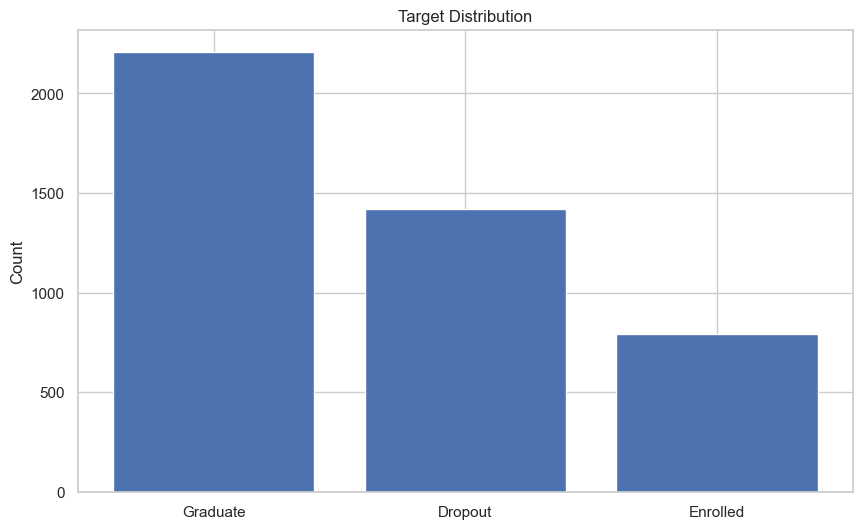

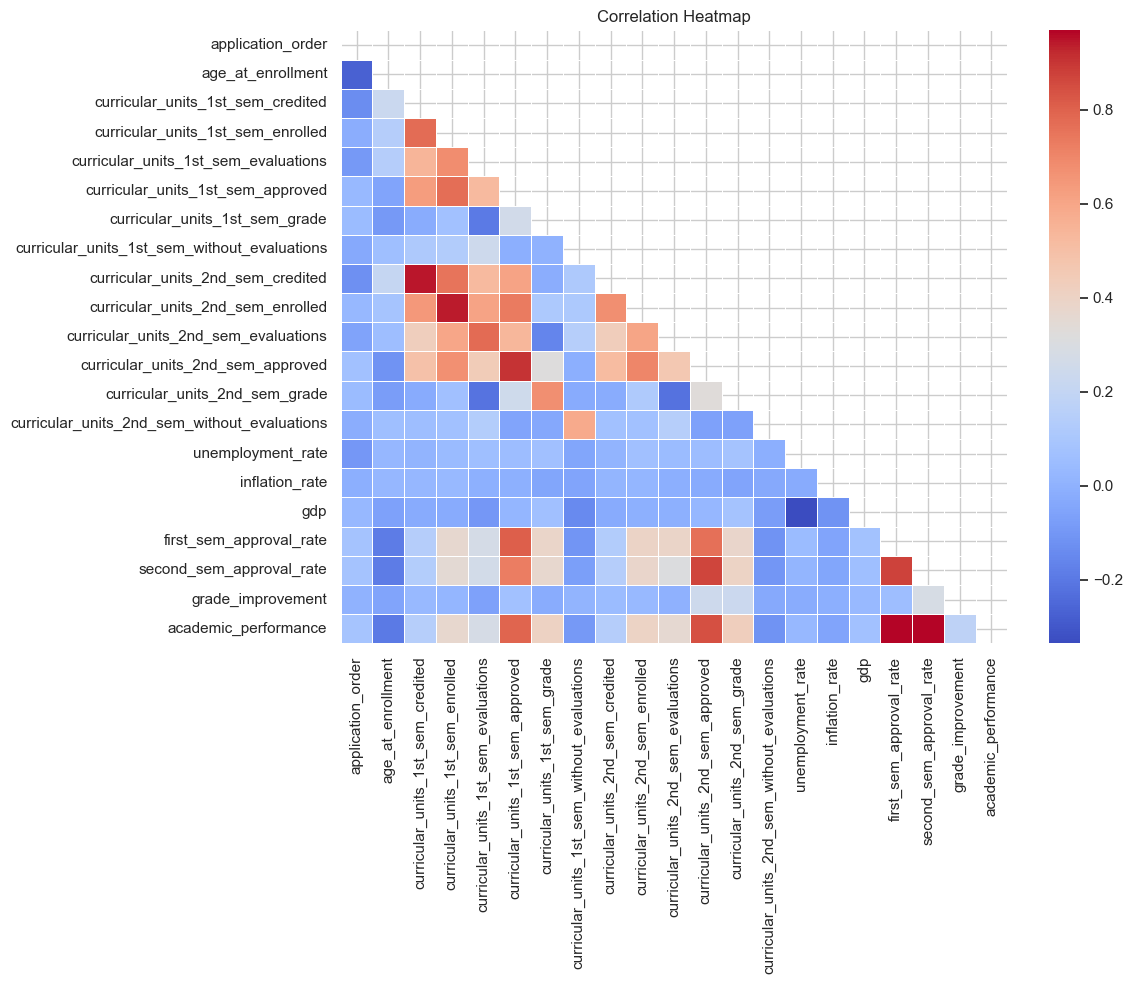

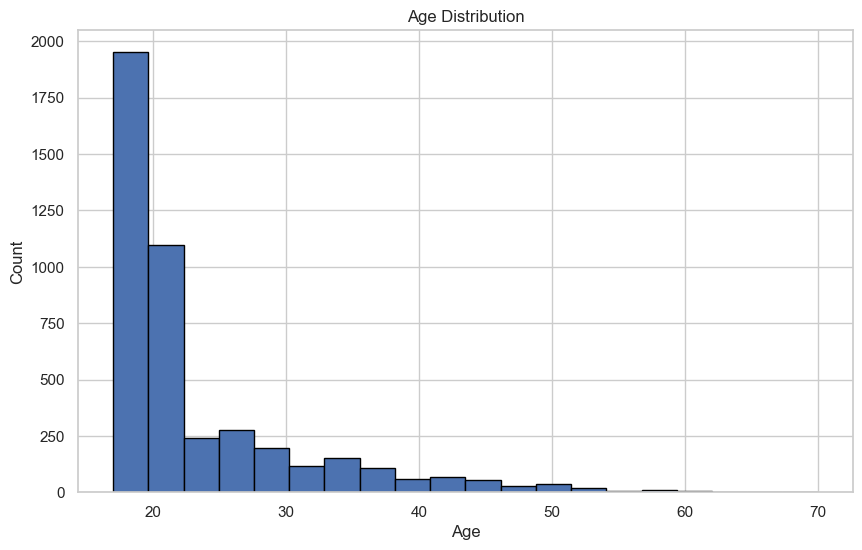

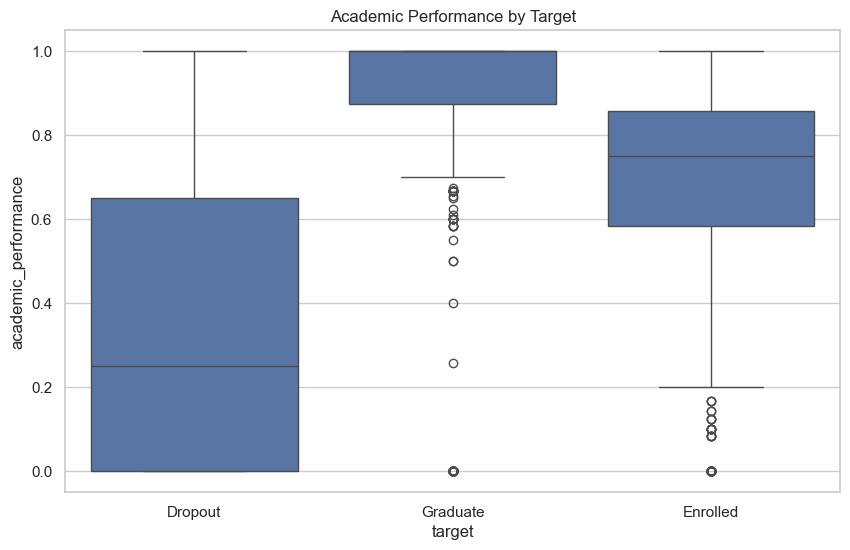

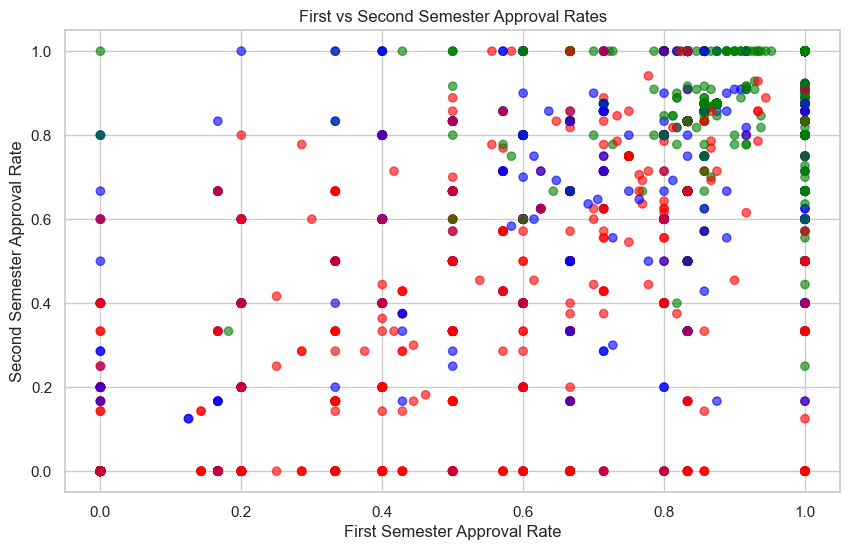

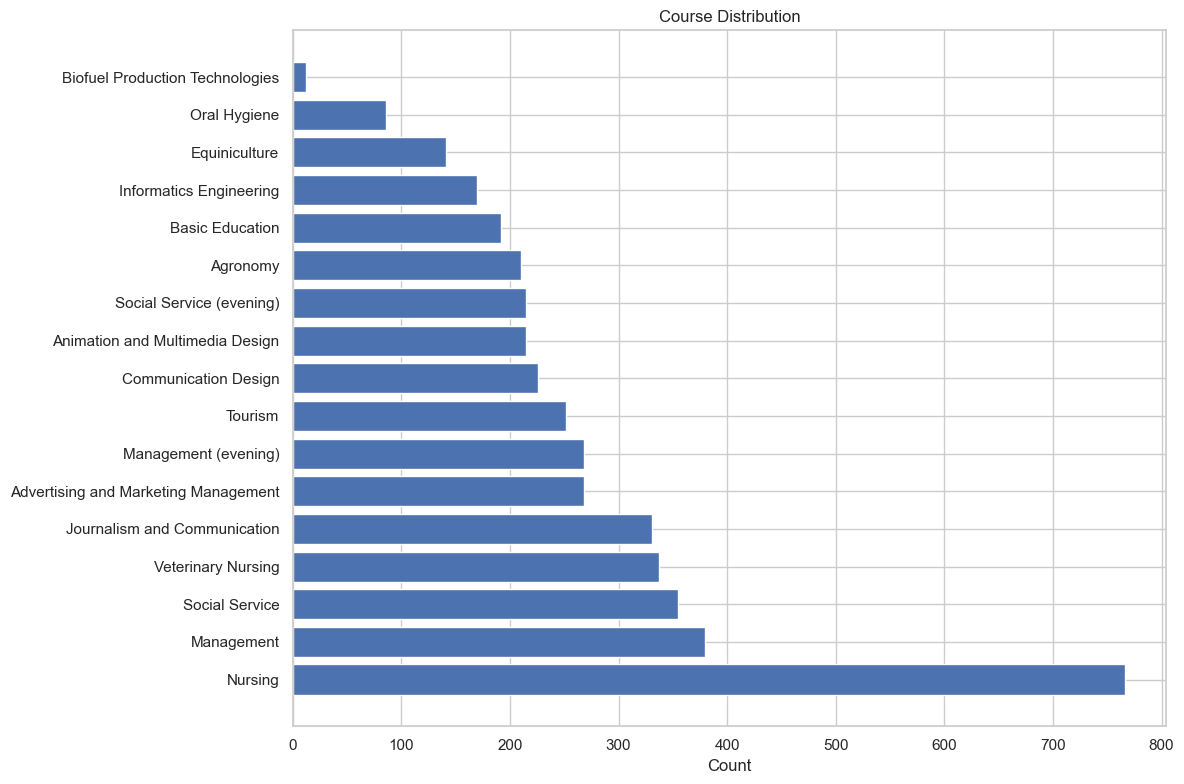

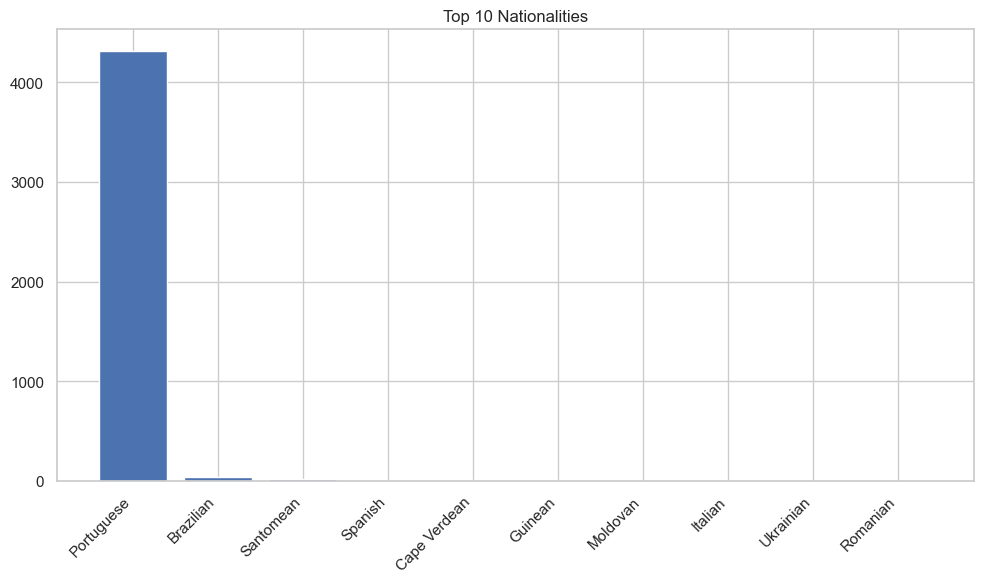

<Figure size 1000x600 with 0 Axes>

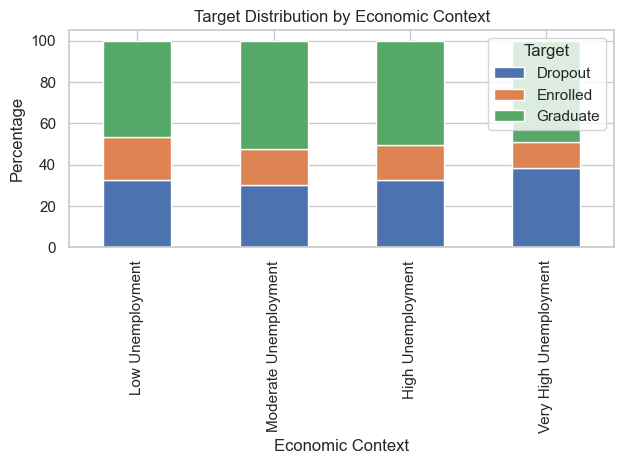


Key Statistics:
target distribution: target
Graduate    49.932188
Dropout     32.120253
Enrolled    17.947559
Name: proportion, dtype: float64
Average age at enrollment: 23.27
Average academic performance: 0.68
Most common course: Nursing
Most common nationality: Portuguese


In [26]:
print("\n📊 STEP 9: Performing basic EDA and generating HTML report...")

# Create a directory for visualizations
if not os.path.exists('reports/figures'):
    os.makedirs('reports/figures')

# 1. target distribution
plt.figure(figsize=(10, 6))
target_counts = df['target'].value_counts()
plt.bar(target_counts.index, target_counts.values)
plt.title('target Distribution')
plt.ylabel('Count')
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['number'])
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 3. Age distribution
plt.figure(figsize=(10, 6))
plt.hist(df['age_at_enrollment'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 4. Academic performance by target
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='academic_performance', data=df)
plt.title('Academic Performance by target')
plt.show()

# 5. First semester vs second semester approval rates
plt.figure(figsize=(10, 6))
plt.scatter(df['first_sem_approval_rate'], df['second_sem_approval_rate'], 
           c=df['target'].map({'Dropout': 'red', 'Graduate': 'green', 'Enrolled': 'blue'}),
           alpha=0.6)
plt.title('First vs Second Semester Approval Rates')
plt.xlabel('First Semester Approval Rate')
plt.ylabel('Second Semester Approval Rate')
plt.grid(True)
plt.show()

# 6. Course distribution
plt.figure(figsize=(12, 8))
course_counts = df['course'].value_counts().sort_values(ascending=False)
plt.barh(range(len(course_counts)), course_counts.values)
plt.yticks(range(len(course_counts)), course_counts.index)
plt.title('Course Distribution')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# 7. Nationality distribution
plt.figure(figsize=(10, 6))
nationality_counts = df['nationality'].value_counts().head(10)
plt.bar(nationality_counts.index, nationality_counts.values)
plt.title('Top 10 Nationalities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 8. Economic context by target
plt.figure(figsize=(10, 6))
economic_target = pd.crosstab(df['economic_context'], df['target'], normalize='index') * 100
economic_target.plot(kind='bar', stacked=True)
plt.title('target Distribution by Economic Context')
plt.xlabel('Economic Context')
plt.ylabel('Percentage')
plt.legend(title='target')
plt.tight_layout()
plt.show()

# Print key statistics
print("\nKey Statistics:")
print(f"target distribution: {df['target'].value_counts(normalize=True) * 100}")
print(f"Average age at enrollment: {df['age_at_enrollment'].mean():.2f}")
print(f"Average academic performance: {df['academic_performance'].mean():.2f}")
print(f"Most common course: {df['course'].value_counts().index[0]}")
print(f"Most common nationality: {df['nationality'].value_counts().index[0]}")


## STEP 10: Validation and delivery of final code
### Explanation:
- Prepares features for classification model
- Splits data into training and test sets
- Trains a Random Forest classifier
- Evaluates performance with classification metrics
- Checks possible overfitting
- Creates process summary and generated files

In [27]:
print("\n✅ STEP 10: Validating and delivering final code...")

# Prepare a model to validate the data quality
print("Validating data quality with a simple model...")

# Select features for classification
features = [
    'age_at_enrollment', 'first_sem_approval_rate', 'second_sem_approval_rate',
    'curricular_units_1st_sem_grade', 'curricular_units_2nd_sem_grade',
    'curricular_units_1st_sem_approved', 'curricular_units_2nd_sem_approved',
    'grade_improvement', 'academic_performance', 'unemployment_rate'
]

# Prepare X and y
X = combined_df[features].copy()
y = combined_df['target'].copy()

# Handle any remaining NaN values
X = X.fillna(X.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train a Random Forest classifier
print("\nTraining a Random Forest classifier to validate data quality...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")

# Check for overfitting
overfitting_diff = train_accuracy - test_accuracy
print(f"Difference (train-test): {overfitting_diff:.4f} ({overfitting_diff*100:.2f}%)")
if overfitting_diff < 0.05:
    print("✅ Model shows minimal overfitting (< 5%)")
else:
    print("⚠️ Model shows signs of overfitting (> 5%)")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\n✨ All processing steps completed successfully!")


✅ STEP 10: Validating and delivering final code...
Validating data quality with a simple model...
Training set: 3236 samples
Testing set: 1388 samples

Training a Random Forest classifier to validate data quality...
Training accuracy: 0.9759
Testing accuracy: 0.7305
Difference (train-test): 0.2453 (24.53%)
⚠️ Model shows signs of overfitting (> 5%)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.75      0.71      0.73       446
    Enrolled       0.44      0.37      0.40       250
    Graduate       0.80      0.87      0.83       692

    accuracy                           0.73      1388
   macro avg       0.66      0.65      0.66      1388
weighted avg       0.72      0.73      0.72      1388


✨ All processing steps completed successfully!


###